# Image Style-Transfer with Convolutional Neural Networks


In this notebook, we’ll create a style-transfer method by utilizing convolutional neural networks. In style-transfer method, we attempt to modify the style of an image while preserving its content. The general idea is to take two images, and produce a new image that reflects the content of one but the artistic style of the other. The implementation of the style-transfer method will be performed in PyTorch.  

In this notebook, we will implement the style transfer technique from the article [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). In this article, style transfer uses the features found in the 19-layer VGG Network (VGG19), which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. The structure of VGG19 is shown below:

<img src='assets/VGG19.jpg'/>


### Creating a style-transfer method

1. First, we take content image and style images and resize them to equal shapes. 
2. Then, we load a pre-trained VGG19.
3. Knowing that we can distinguish layers that are responsible for the style (basic shapes, colors etc.) and the ones responsible for the content (image-specific features), we can separate the layers to independently work on the content and style.
4. Then we set our task as an optimization problem where we are going to minimize:
   - **content loss**, i.e., the distance between the input and output images. We minimize this loss to preserve the content of the image. 
   - **style loss**, i.e., the distance between the style and output images. We minimize this loss to apply a new style to an image.
   - **total variation loss**, i.e., regularization - spatial smoothness to denoise the output image.
5. Finally, we set our gradients and optimize with the Adam optimizer.

In [1]:
# Image-related packages
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

# Data-related package
import numpy as np

# Deep-learning-related packages
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

---
## 1.0. Load in Image
### 1.1. Create Function to Load in Image

We create `load_image` function to load content and style images, and to convert the images to normalized Tensors. This function will also resize the images to smaller size. 

In [2]:
def load_image(img_path, max_size=400, shape=None):    
    # Load an image
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # Resize the image according to max_size or shape
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

We also need a function to un-normalize an image and convert it from a Tensor image to a NumPy image for display. Therefore, we create `im_convert` function.

In [3]:
def im_convert(tensor):
    # Display a tensor as an image
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

### 1.2. Load in Content and Style Image
In style-transfer method, we need two images:
- **content image**: we will extract the objects and the arrangement of this image.
- **style image**: we will extract the style, colors, and textures of this image.

Let's load content and style image using `load_image` function.

In [4]:
# Move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load in content image
content = load_image('images/content.jpg').to(device)

# Load in style image and match the size of the style image with the size of the content image
style = load_image('images/style.jpg', shape=content.shape[-2:]).to(device)

Let's display the loaded content and style image.

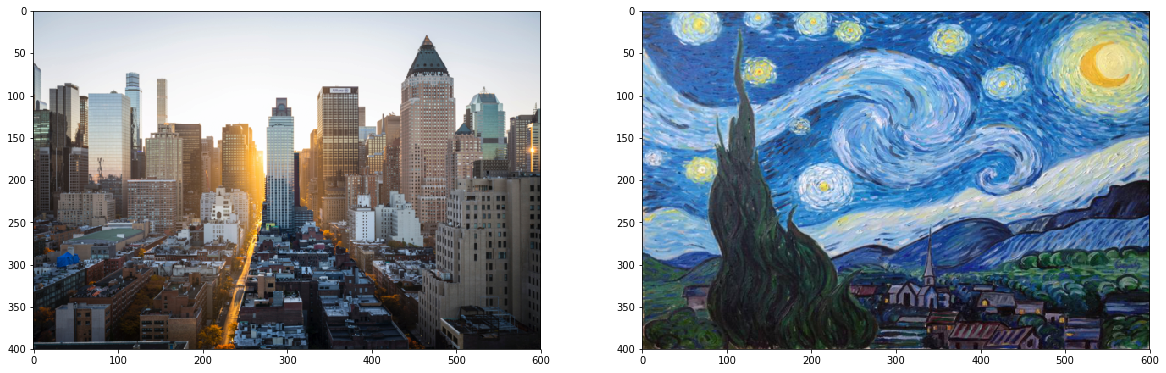

In [5]:
# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## 2.0. Load in VGG19
### 2.1. Load in Pre-Trained VGG19 

We need to extract the `features` portion of VGG19, which comprise of all the convolutional and pooling layers. Then, we freeze all VGG parameters since we are only optimizing the target image.

In [6]:
# Get the features portion of VGG19
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters 
for param in vgg.parameters():
    param.requires_grad_(False)

### 2.2. Show VGG19 Structure

In [7]:
# Show VGG19 structure
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

---
## 3.0. Separate Content and Style Features
Knowing that we can distinguish layers that are responsible for the style (basic shapes, colors etc.) and the ones responsible for the content (objects and arrangements), we can separate the layers to independently work on the content and style. 

### 3.1. Get Features

It is stated on the Gatys' article that the layer that makes up the content representation of an image is `conv4_2` (the fourth convolutional layer in the second stack). Meawhile, the layers that make up the content representation of an image are the following:
- `conv1_1`: the first convolutional layer in the first stack. 
- `conv2_1`: the second convolutional layer in the first stack. 
- `conv3_1`: the third convolutional layer in the first stack. 
- `conv4_1`: the fourth convolutional layer in the first stack. 
- `conv5_1`: the fifth convolutional layer in the first stack. 
We define `get_features` function to get the features for a set of layers.

In [8]:
def get_features(image, model, layers=None):
    ## Define the layers for the content and style representations of an image
    ## Default layers are for VGGNet matching Gatys et al (2016)
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### 3.2. Calculate Gram Matrix 

We will use gram matrix to measure the degree of correlation between channels which later will act as a measure of the style itself. To get an intuition about gram matrix, you can read this [article](https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f). 

In [9]:
def gram_matrix(tensor):
    # Get the depth, height, and width of a tensor
    _, d, h, w = tensor.size()
    # Reshape that tensor so that the spatial dimensions (height and width) are flattened
    tensor = tensor.view(d, h * w)
    # Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

---
## 4.0. Define Weights, Calculate Loss, and Update Image

### 4.1. Define Weights

#### Content and Style Weight

The content and style weight affect how much the combined image will be influenced by the content and style image. If the style weight is larger than content weight, the content image will have more influence than the style weight, and vice versa.  

#### Individual Layer Style Weights

We also define the weight of each layer style. If we choose to put more weights on earlier layers, the resulting image will have larger style artifacts. If we choose to put more weights on later layers, the resulting image will have smaller style artifacts. 

We define the weights below. 

In [10]:
# Define content and style weight
content_weight = 1  
style_weight = 1e6  

# Define individual layer style weights
style_weights = {'conv1_1': 0.8,
                 'conv2_1': 0.6,
                 'conv3_1': 0.4,
                 'conv4_1': 0.2,
                 'conv5_1': 0.1}

### 4.2. Calculate Loss and Update Image

We need to calculate three types of loss:
- **Content Loss**: Content loss measures how much the feature map of the generated image differs from the feature map of the source image. The content loss will be the mean squared difference between the target and content features at a specific layer.
- **Style Loss**: We calculate style loss in a similar way. The difference is that we have to iterate through a number of layers.
- **Total Loss**: We will add up the content and style losses and weight them with the pre-defined content and style weight.

We aim to create a new, target image which should contain our desired content and style components. The losses are used to iteratively update the target image. Thus, we need to define the number of steps to update the image. 

In [12]:
# Get content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a target image, which is a clone of our content image
target = content.clone().requires_grad_(True).to(device)

# Define the type of optimizer and the number of steps to update the image
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  

# Iteratively update the target image
for ii in range(1, steps+1):
    
    # Get the features from the target image
    target_features = get_features(target, vgg)
    
    # Calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # Calculate the style loss. Style loss is initialized to 0
    style_loss = 0
    # The style loss is then added to each layer's gram matrix loss
    for layer in style_weights:
        # Get the style representation for the layer in the target image
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # Get the style representation for the layer in the style image
        style_gram = style_grams[layer]
        # Calculate the style loss for the layer
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # Add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # Calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Update the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

---
## 5.0. Show the Results

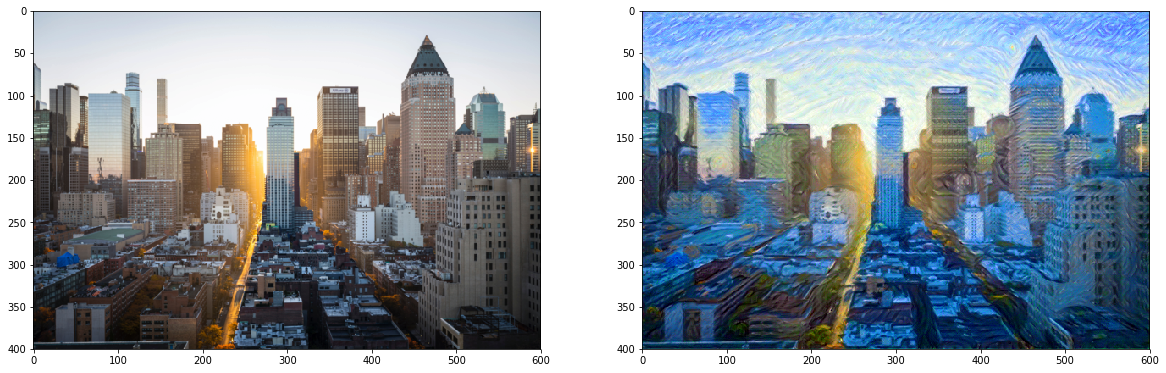

In [13]:
# Display target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))